# Table of Contents

* [Setup Environment](#section1)
* [Functions](#section2)
* [1950-1959](#section3)
    * [Topic Modeling](#section_3_1)
        * [Check Coherence](#section_3_1_1)
        * [Save Final Model](#section_3_1_2)
    * [Explore Model](#section_3_2)
        * [Extracting Topics](#section_3_2_1)
        * [Visualizations](#section_3_2_2)
* [1960-1969](#section4)
    * [Topic Modeling](#section_4_1)
        * [Check Coherence](#section_4_1_1)
        * [Save Final Model](#section_4_1_2)
    * [Explore Model](#section_4_2)
        * [Extracting Topics](#section_4_2_1)
        * [Visualizations](#section_4_2_2)
* [1970-1979](#section5)
    * [Topic Modeling](#section_5_1)
        * [Check Coherence](#section_5_1_1)
        * [Save Final Model](#section_5_1_2)
    * [Explore Model](#section_5_2)
        * [Extracting Topics](#section_5_2_1)
        * [Visualizations](#section_5_2_2)
* [1980-1989](#section6)
    * [Topic Modeling](#section_6_1)
        * [Check Coherence](#section_6_1_1)
        * [Save Final Model](#section_6_1_2)
    * [Explore Model](#section_6_2)
        * [Extracting Topics](#section_6_2_1)
        * [Visualizations](#section_6_2_2)
* [1990-1999](#section7)
    * [Topic Modeling](#section_7_1)
        * [Check Coherence](#section_7_1_1)
        * [Save Final Model](#section_7_1_2)
    * [Explore Model](#section_7_2)
        * [Extracting Topics](#section_7_2_1)
        * [Visualizations](#section_7_2_2)
* [2000-2009](#section8)
    * [Topic Modeling](#section_8_1)
        * [Check Coherence](#section_8_1_1)
        * [Save Final Model](#section_8_1_2)
    * [Explore Model](#section_8_2)
        * [Extracting Topics](#section_8_2_1)
        * [Visualizations](#section_8_2_2)
* [2010-2019](#section9)
    * [Topic Modeling](#section_9_1)
        * [Check Coherence](#section_9_1_1)
        * [Save Final Model](#section_9_1_2)
    * [Explore Model](#section_9_2)
        * [Extracting Topics](#section_9_2_1)
        * [Visualizations](#section_9_2_2)

# Setup Environment <a class=anchor id=section1></a>

In [2]:
%%capture
# use ml.c5.2xlarge or ml.g4dn.xlarge instance
!apt-get update
!apt-get install --reinstall build-essential --yes

In [3]:
%%capture
!pip install bertopic
!pip install farm-haystack
!pip install spacy
!pip install gensim
!pip install sagemaker_pyspark
!python -m spacy download en_core_web_sm

In [4]:
import re
import glob
import spacy
import gensim
import pickle
import logging
import pyspark
import pynndescent
import numpy as np
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from haystack.nodes import PreProcessor
from gensim.utils import simple_preprocess
from nltk.corpus import PlaintextCorpusReader
from haystack.utils import convert_files_to_docs
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel

np.random.seed(0)
pio.renderers.default='iframe'
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
pynndescent.rp_trees.FlatTree.__module__  = "pynndescent.rp_trees"
logging.getLogger("haystack.utils.preprocessing").setLevel(logging.ERROR)

In [5]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from transformers.pipelines import pipeline
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
nltk.download('omw-1.4')
token_pattern = re.compile(r"(?u)\b\w\w+\b")
sentence_model = SentenceTransformer("all-distilroberta-v1")
# sentence_model = SentenceTransformer("allenai/longformer-large-4096")
# sentence_model = SentenceTransformer("Peltarion/xlm-roberta-longformer-base-4096")
# sentence_model = SentenceTransformer("google/reformer-enwik8")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if len(t) > 3 and re.match("[a-z].*", t) and re.match(token_pattern, t)
        ]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Functions <a class=anchor id=section2></a>

In [6]:
def pre_process(source):
    processed_docs = []
    all_docs = convert_files_to_docs(dir_path=source)
    selected_docs = [doc for doc in all_docs if len(doc.content.split()) >= 10]
    preprocessor = PreProcessor(
        clean_empty_lines=True,
        clean_whitespace=True,
        clean_header_footer=True,
        split_by=None
    )
    processed_docs = [item.content for item in preprocessor.process(selected_docs)]
    print(f"Number of input files: {len(all_docs)}\n"+
          f"Number of selected files: {len(selected_docs)}\n"+
          f"Number of output files: {len(processed_docs)}")
    return processed_docs
"""
def pre_process(source):
    all_docs = convert_files_to_docs(dir_path=source)
    preprocessor = PreProcessor(
        clean_empty_lines=True,
        clean_whitespace=True,
        clean_header_footer=False,
        split_by="word",
        split_length=500,
        split_respect_sentence_boundary=True,
    )
    processed_docs = preprocessor.process(all_docs)
    print(f"Number of input files: {len(all_docs)}\nNumber of output files: {len(processed_docs)}")
    return [item.content for item in processed_docs]

"""

'\ndef pre_process(source):\n    all_docs = convert_files_to_docs(dir_path=source)\n    preprocessor = PreProcessor(\n        clean_empty_lines=True,\n        clean_whitespace=True,\n        clean_header_footer=False,\n        split_by="word",\n        split_length=500,\n        split_respect_sentence_boundary=True,\n    )\n    processed_docs = preprocessor.process(all_docs)\n    print(f"Number of input files: {len(all_docs)}\nNumber of output files: {len(processed_docs)}")\n    return [item.content for item in processed_docs]\n\n'

In [7]:
def training(docs, docs_embeddings, cluster_size=100):
    vectorizer_model= CountVectorizer(stop_words="english", tokenizer=LemmaTokenizer())
    # Set the random state in the UMAP model to prevent stochastic behavior 
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=cluster_size, metric='euclidean', prediction_data=True)
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, nr_topics="auto", 
                           vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
    topics, probs = topic_model.fit_transform(docs, docs_embeddings)
    
    ##### Calculate Coherence
    # Preprocess Documents
    documents = pd.DataFrame({"Document": docs,
                              "ID": range(len(docs)),
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, probs in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_npmi')
    coherence_score = coherence_model.get_coherence()

    return topic_model, topics, probs, coherence_score

In [8]:
def draw_graph(start, limit, step, c_npmi, title):
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, c_npmi)
    plt.title(title)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Coherence score")
    plt.legend(("c_npmi"), loc='best')
    plt.show()
    # Print the coherence scores
#     for i in range(0,len(c_npmi)):
#         if str(c_npmi[i]) == 'nan':
#             c_npmi[i]=float('-inf')
    maximum = max(c_npmi)
    indices = [i for i, v in enumerate(c_npmi) if v == maximum]
    print("A maximum {} score of {} was achieved at K={}".format("c_npmi", maximum, indices[0]+1))
    # Return the index
    return indices[0]

In [8]:
!rm -r BERT/
!mkdir BERT

# 1950-1959 <a class=anchor id=section3></a>

## Topic Modeling <a class=anchor id=section_3_1></a>

In [9]:
!mkdir BERT/1950-1959/

In [10]:
# parameters
source = 'CLEANSED/1950-1959'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [11]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

100%|██████████| 1051/1051 [00:00<00:00, 31317.01docs/s]


Number of input files: 1051
Number of selected files: 1051
Number of output files: 1051


In [12]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

2022-08-11 14:26:24,256 - BERTopic - Reduced dimensionality
2022-08-11 14:26:24,330 - BERTopic - Clustered reduced embeddings
2022-08-11 14:26:47,490 - BERTopic - Reduced number of topics from 17 to 17
2022-08-11 14:27:02,911 - BERTopic - Reduced dimensionality
2022-08-11 14:27:02,976 - BERTopic - Clustered reduced embeddings
2022-08-11 14:27:24,617 - BERTopic - Reduced number of topics from 11 to 11
2022-08-11 14:27:39,424 - BERTopic - Reduced dimensionality
2022-08-11 14:27:39,486 - BERTopic - Clustered reduced embeddings
2022-08-11 14:28:01,234 - BERTopic - Reduced number of topics from 7 to 7
2022-08-11 14:28:15,672 - BERTopic - Reduced dimensionality
2022-08-11 14:28:15,737 - BERTopic - Clustered reduced embeddings
2022-08-11 14:28:37,431 - BERTopic - Reduced number of topics from 7 to 7
2022-08-11 14:28:51,904 - BERTopic - Reduced dimensionality
2022-08-11 14:28:51,970 - BERTopic - Clustered reduced embeddings
2022-08-11 14:29:13,705 - BERTopic - Reduced number of topics from 6 t

### Check Coherence <a class=anchor id=section_3_1_1></a>

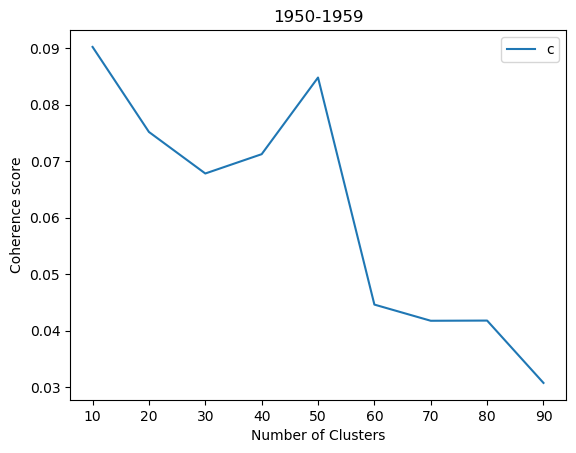

A maximum c_npmi score of 0.0902134197630636 was achieved at K=1


In [13]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_3_1_2></a>

In [14]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 15/15 [00:00<00:00, 177.06it/s]


In [15]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

## Explore Model <a class=anchor id=section_3_2></a>

In [16]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)

### Extracting Topics <a class=anchor id=section_3_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [17]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,285,-1_year_company_permission_state
1,0,138,0_automation_machine_said_permission
2,1,99,1_share_fund_company_stock
3,2,86,2_union_labor_worker_wage
4,3,71,3_news_film_music_wcbs


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [18]:
# Select the most frequent topic
topic_model.get_topic(0)

[('automation', 0.03537526957501793),
 ('machine', 0.025013740902060967),
 ('said', 0.023085837736204786),
 ('permission', 0.021154589245557694),
 ('education', 0.02095601782387554),
 ('school', 0.020389398662656114),
 ('worker', 0.01744079990478005),
 ('work', 0.016869637998127282),
 ('time', 0.015276450935803803),
 ('automatic', 0.013790583548082137)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_3_2_2></a>

In [19]:
topic_model.visualize_topics()

In [20]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [21]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [22]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [23]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [24]:
topic_model.visualize_term_rank()

# 1960-1969 <a class=anchor id=section4></a>

## Topic Modeling <a class=anchor id=section_4_1></a>

In [25]:
!mkdir BERT/1960-1969/

In [26]:
# parameters
source = 'CLEANSED/1960-1969'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [27]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

100%|██████████| 2900/2900 [00:00<00:00, 37487.35docs/s]


Number of input files: 2900
Number of selected files: 2900
Number of output files: 2900


In [28]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

2022-08-11 14:33:22,479 - BERTopic - Reduced dimensionality
2022-08-11 14:33:22,893 - BERTopic - Clustered reduced embeddings
2022-08-11 14:34:11,390 - BERTopic - Reduced number of topics from 50 to 30
2022-08-11 14:34:53,380 - BERTopic - Reduced dimensionality
2022-08-11 14:34:53,612 - BERTopic - Clustered reduced embeddings
2022-08-11 14:35:41,743 - BERTopic - Reduced number of topics from 25 to 9
2022-08-11 14:36:20,411 - BERTopic - Reduced dimensionality
2022-08-11 14:36:20,620 - BERTopic - Clustered reduced embeddings
2022-08-11 14:37:08,747 - BERTopic - Reduced number of topics from 18 to 8
2022-08-11 14:37:47,758 - BERTopic - Reduced dimensionality
2022-08-11 14:37:47,948 - BERTopic - Clustered reduced embeddings
2022-08-11 14:38:36,026 - BERTopic - Reduced number of topics from 12 to 12
2022-08-11 14:39:16,349 - BERTopic - Reduced dimensionality
2022-08-11 14:39:16,534 - BERTopic - Clustered reduced embeddings
2022-08-11 14:40:04,801 - BERTopic - Reduced number of topics from 7

### Check Coherence <a class=anchor id=section_4_1_1></a>

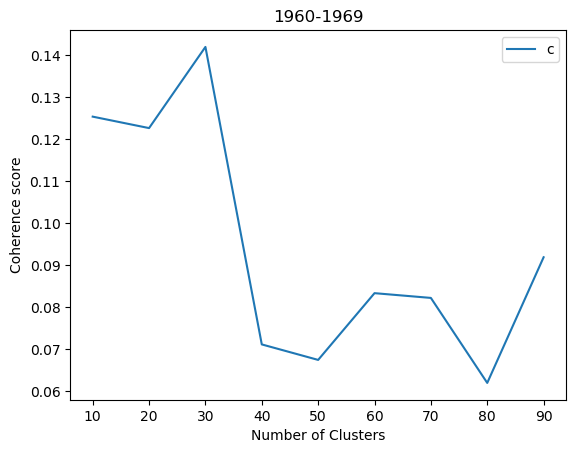

A maximum c_npmi score of 0.1419180365407465 was achieved at K=3


In [29]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_4_1_2></a>

In [30]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 6/6 [00:00<00:00, 140.98it/s]


In [31]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

## Explore Model <a class=anchor id=section_4_2></a>

In [32]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)

### Extracting Topics <a class=anchor id=section_4_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [33]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,1102,-1_said_permission_year_company
1,0,1207,0_union_said_permission_labor
2,1,232,1_exchange_stock_share_market
3,2,189,2_newspaper_union_publisher_guild
4,3,51,3_sale_income_cent_earns


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [34]:
# Select the most frequent topic
topic_model.get_topic(0)

[('union', 0.02314113104298933),
 ('said', 0.022883547551849456),
 ('permission', 0.022496067463633137),
 ('labor', 0.020889312400700175),
 ('year', 0.01948904740161269),
 ('automation', 0.017138008789913974),
 ('worker', 0.015491843242717263),
 ('president', 0.015476038924248979),
 ('industry', 0.014844961104739755),
 ('work', 0.014638394255074594)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_4_2_2></a>

In [35]:
topic_model.visualize_topics()

In [36]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [37]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [38]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [39]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [40]:
topic_model.visualize_term_rank()

# 1970-1979 <a class=anchor id=section5></a>

## Topic Modeling <a class=anchor id=section_5_1></a>

In [41]:
!mkdir BERT/1970-1979/

In [42]:
# parameters
source = 'CLEANSED/1970-1979'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 90, 10
topic_models = []
coherences = []
topics = []
probs = []

In [43]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

100%|██████████| 1258/1258 [00:00<00:00, 20267.63docs/s]


Number of input files: 1258
Number of selected files: 1258
Number of output files: 1258


In [44]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

2022-08-11 14:47:07,497 - BERTopic - Reduced dimensionality
2022-08-11 14:47:07,625 - BERTopic - Clustered reduced embeddings
2022-08-11 14:47:47,165 - BERTopic - Reduced number of topics from 34 to 20
2022-08-11 14:48:12,572 - BERTopic - Reduced dimensionality
2022-08-11 14:48:12,656 - BERTopic - Clustered reduced embeddings
2022-08-11 14:48:52,364 - BERTopic - Reduced number of topics from 5 to 5
2022-08-11 14:49:14,017 - BERTopic - Reduced dimensionality
2022-08-11 14:49:14,088 - BERTopic - Clustered reduced embeddings
2022-08-11 14:49:53,237 - BERTopic - Reduced number of topics from 2 to 2
2022-08-11 14:50:14,585 - BERTopic - Reduced dimensionality
2022-08-11 14:50:14,656 - BERTopic - Clustered reduced embeddings
2022-08-11 14:50:53,778 - BERTopic - Reduced number of topics from 2 to 2
2022-08-11 14:51:14,736 - BERTopic - Reduced dimensionality
2022-08-11 14:51:14,816 - BERTopic - Clustered reduced embeddings
2022-08-11 14:51:54,052 - BERTopic - Reduced number of topics from 4 to 

### Check Coherence <a class=anchor id=section_5_1_1></a>

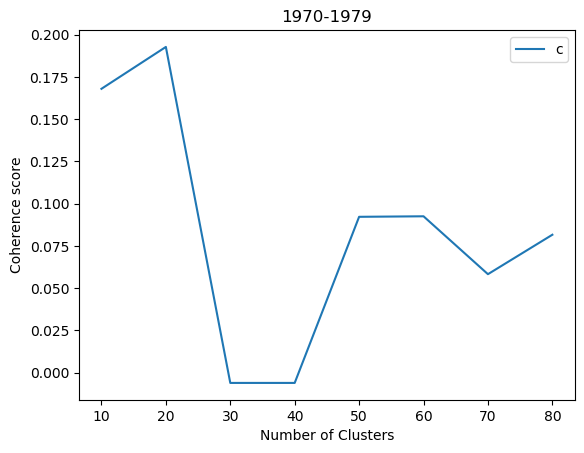

A maximum c_npmi score of 0.19269954092848232 was achieved at K=2


In [45]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_5_1_2></a>

In [46]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 3/3 [00:00<00:00, 95.00it/s]


In [47]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

## Explore Model <a class=anchor id=section_5_2></a>

In [48]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)

### Extracting Topics <a class=anchor id=section_5_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [49]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,46,-1_movie_news_guest_report
1,0,1120,0_income_said_year_earns
2,1,44,1_hunter_horse_farm_green
3,2,26,2_camera_lens_exposure_film
4,3,22,3_stock_market_share_exchange


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [50]:
# Select the most frequent topic
topic_model.get_topic(0)

[('income', 0.024272644983928036),
 ('said', 0.023903807690403157),
 ('year', 0.023513617058730635),
 ('earns', 0.02277150923535754),
 ('sale', 0.020007501343199525),
 ('permission', 0.017755781085233666),
 ('company', 0.017714559452327496),
 ('york', 0.017237712625074217),
 ('union', 0.015906171753256818),
 ('time', 0.015142603688551597)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_5_2_2></a>

In [51]:
topic_model.visualize_topics()

In [52]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [53]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [54]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [55]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [56]:
topic_model.visualize_term_rank()

# 1980-1989 <a class=anchor id=section6></a>

## Topic Modeling <a class=anchor id=section_6_1></a>

In [57]:
!mkdir BERT/1980-1989/

In [58]:
# parameters
source = 'CLEANSED/1980-1989'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [59]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

100%|██████████| 1753/1753 [00:00<00:00, 53823.91docs/s]


Number of input files: 1771
Number of selected files: 1753
Number of output files: 1753


In [60]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

2022-08-11 14:56:13,536 - BERTopic - Reduced dimensionality
2022-08-11 14:56:13,770 - BERTopic - Clustered reduced embeddings
2022-08-11 14:56:55,247 - BERTopic - Reduced number of topics from 45 to 36
2022-08-11 14:57:24,946 - BERTopic - Reduced dimensionality
2022-08-11 14:57:25,091 - BERTopic - Clustered reduced embeddings
2022-08-11 14:58:06,013 - BERTopic - Reduced number of topics from 24 to 24
2022-08-11 14:58:34,916 - BERTopic - Reduced dimensionality
2022-08-11 14:58:35,048 - BERTopic - Clustered reduced embeddings
2022-08-11 14:59:15,950 - BERTopic - Reduced number of topics from 17 to 15
2022-08-11 14:59:44,391 - BERTopic - Reduced dimensionality
2022-08-11 14:59:44,492 - BERTopic - Clustered reduced embeddings
2022-08-11 15:00:25,208 - BERTopic - Reduced number of topics from 2 to 2
2022-08-11 15:00:50,524 - BERTopic - Reduced dimensionality
2022-08-11 15:00:50,625 - BERTopic - Clustered reduced embeddings
2022-08-11 15:01:31,468 - BERTopic - Reduced number of topics from 3

### Check Coherence <a class=anchor id=section_6_1_1></a>

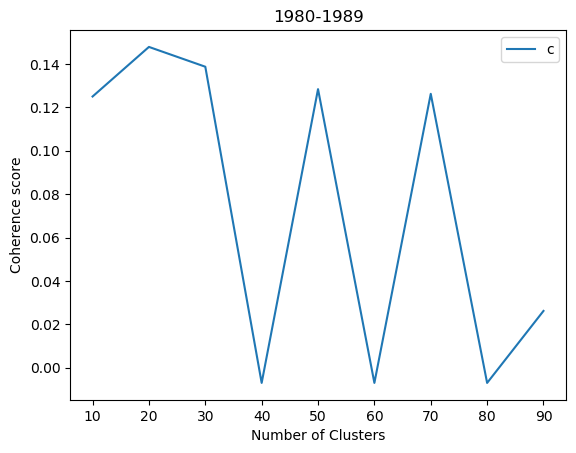

A maximum c_npmi score of 0.14789910722984756 was achieved at K=2


In [61]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_6_1_2></a>

In [62]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 22/22 [00:00<00:00, 165.53it/s]


In [63]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

## Explore Model <a class=anchor id=section_6_2></a>

In [64]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)

### Extracting Topics <a class=anchor id=section_6_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [65]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,574,-1_company_said_year_percent
1,0,135,0_robot_technology_said_computer
2,1,89,1_corp_share_said_million
3,2,83,2_percent_rate_american_trade
4,3,73,3_company_said_sperry_year


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [66]:
# Select the most frequent topic
topic_model.get_topic(0)

[('robot', 0.03493211395810116),
 ('technology', 0.020912296671274807),
 ('said', 0.019525142647548205),
 ('computer', 0.017130758482378734),
 ('manufacturing', 0.016750894959091482),
 ('company', 0.016611299517841467),
 ('work', 0.016300209506298055),
 ('industry', 0.016053546477902178),
 ('worker', 0.015321846720960751),
 ('job', 0.015306741150885126)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_6_2_2></a>

In [67]:
topic_model.visualize_topics()

In [68]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [69]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [70]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [71]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [72]:
topic_model.visualize_term_rank()

# 1990-1999 <a class=anchor id=section7></a>

## Topic Modeling <a class=anchor id=section_7_1></a>

In [9]:
!mkdir BERT/1990-1999/

In [9]:
# parameters
source = 'CLEANSED/1990-1999'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [10]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

100%|██████████| 1368/1368 [00:00<00:00, 50834.19docs/s]


Number of input files: 1520
Number of selected files: 1368
Number of output files: 1368


In [11]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

2022-08-11 17:43:43,425 - BERTopic - Reduced dimensionality
2022-08-11 17:43:43,585 - BERTopic - Clustered reduced embeddings
2022-08-11 17:44:20,144 - BERTopic - Reduced number of topics from 38 to 30
2022-08-11 17:44:43,661 - BERTopic - Reduced dimensionality
2022-08-11 17:44:43,760 - BERTopic - Clustered reduced embeddings
2022-08-11 17:45:18,507 - BERTopic - Reduced number of topics from 18 to 18
2022-08-11 17:45:41,402 - BERTopic - Reduced dimensionality
2022-08-11 17:45:41,478 - BERTopic - Clustered reduced embeddings
2022-08-11 17:46:15,968 - BERTopic - Reduced number of topics from 3 to 3
2022-08-11 17:46:36,484 - BERTopic - Reduced dimensionality
2022-08-11 17:46:36,563 - BERTopic - Clustered reduced embeddings
2022-08-11 17:47:11,218 - BERTopic - Reduced number of topics from 3 to 3
2022-08-11 17:47:31,660 - BERTopic - Reduced dimensionality
2022-08-11 17:47:31,739 - BERTopic - Clustered reduced embeddings
2022-08-11 17:48:06,605 - BERTopic - Reduced number of topics from 3 t

In [15]:
topic_ids = topic_model.get_topic_info().Topic.unique().tolist()
[topic_model.get_topic(topic) for topic in topic_ids]

[[('said', 0.048171085607054),
  ('company', 0.027623197442618954),
  ('year', 0.02679274852708939),
  ('computer', 0.01958909101065196),
  ('million', 0.018515317464029596),
  ('like', 0.017645453015140918),
  ('time', 0.017580825636998053),
  ('people', 0.015892520283396452),
  ('york', 0.01578072797232747),
  ('state', 0.015260476682421498)],
 [('company', 0.05660602623790258),
  ('said', 0.04400289927878325),
  ('million', 0.03917176710557154),
  ('computer', 0.03740951392983023),
  ('software', 0.026458212104066684),
  ('share', 0.026249292730493975),
  ('business', 0.024831970988136325),
  ('year', 0.02320648690495712),
  ('product', 0.022886438199111875),
  ('automation', 0.022797397369419454)],
 [('worker', 0.04780190990174526),
  ('said', 0.04111000503420654),
  ('company', 0.034381833984917065),
  ('year', 0.031011747325280822),
  ('job', 0.030171526296521672),
  ('percent', 0.029103240366794292),
  ('american', 0.026412814764298926),
  ('work', 0.02618392644160412),
  ('labo

### Check Coherence <a class=anchor id=section_7_1_1></a>

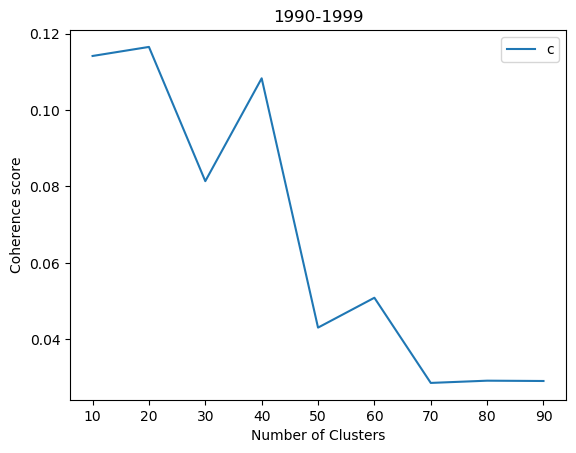

A maximum c_npmi score of 0.11649510416038932 was achieved at K=2


In [14]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_7_1_2></a>

In [16]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 16/16 [00:00<00:00, 155.78it/s]


In [18]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

## Explore Model <a class=anchor id=section_7_2></a>

In [19]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)

### Extracting Topics <a class=anchor id=section_7_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [20]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,510,-1_said_company_year_computer
1,0,131,0_million_share_corp_company
2,1,80,1_rockwell_company_business_software
3,2,79,2_worker_job_said_percent
4,3,73,3_city_said_building_brooklyn


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [21]:
# Select the most frequent topic
topic_model.get_topic(0)

[('million', 0.055715352392836315),
 ('share', 0.04661294174530772),
 ('corp', 0.04636238424162747),
 ('company', 0.04548053795105796),
 ('based', 0.03574370839894761),
 ('said', 0.03375998069500773),
 ('automation', 0.033626537367633005),
 ('unit', 0.032574557193199453),
 ('stock', 0.030267870245962593),
 ('yesterday', 0.028834345045392784)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_7_2_2></a>

In [22]:
topic_model.visualize_topics()

In [23]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [24]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [25]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [26]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [27]:
topic_model.visualize_term_rank()

# 2000-2009 <a class=anchor id=section8></a>

## Topic Modeling <a class=anchor id=section_8_1></a>

In [28]:
!mkdir BERT/2000-2009/

In [29]:
# parameters
source = 'CLEANSED/2000-2009'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [30]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

100%|██████████| 2009/2009 [00:00<00:00, 49641.85docs/s]


Number of input files: 2010
Number of selected files: 2009
Number of output files: 2009


In [31]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

2022-08-11 17:55:43,115 - BERTopic - Reduced dimensionality
2022-08-11 17:55:43,491 - BERTopic - Clustered reduced embeddings
2022-08-11 17:56:36,414 - BERTopic - Reduced number of topics from 60 to 34
2022-08-11 17:57:12,268 - BERTopic - Reduced dimensionality
2022-08-11 17:57:12,438 - BERTopic - Clustered reduced embeddings
2022-08-11 17:58:04,972 - BERTopic - Reduced number of topics from 26 to 23
2022-08-11 17:58:40,274 - BERTopic - Reduced dimensionality
2022-08-11 17:58:40,427 - BERTopic - Clustered reduced embeddings
2022-08-11 17:59:32,711 - BERTopic - Reduced number of topics from 19 to 19
2022-08-11 18:00:07,580 - BERTopic - Reduced dimensionality
2022-08-11 18:00:07,722 - BERTopic - Clustered reduced embeddings
2022-08-11 18:01:00,282 - BERTopic - Reduced number of topics from 15 to 15
2022-08-11 18:01:34,968 - BERTopic - Reduced dimensionality
2022-08-11 18:01:35,103 - BERTopic - Clustered reduced embeddings
2022-08-11 18:02:27,611 - BERTopic - Reduced number of topics from

### Check Coherence <a class=anchor id=section_8_1_1></a>

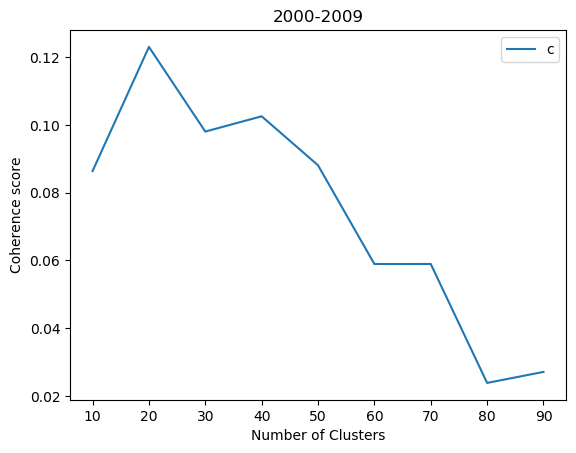

A maximum c_npmi score of 0.12302337918030405 was achieved at K=2


In [32]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_8_1_2></a>

In [33]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 21/21 [00:00<00:00, 145.93it/s]


In [34]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

## Explore Model <a class=anchor id=section_8_2></a>

In [35]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)

### Extracting Topics <a class=anchor id=section_8_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [36]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,549,-1_said_company_year_like
1,0,217,0_software_company_customer_service
2,1,153,1_home_house_said_light
3,2,128,2_airline_plane_flight_pilot
4,3,113,3_job_economy_company_economic


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [37]:
# Select the most frequent topic
topic_model.get_topic(0)

[('software', 0.02849204726584317),
 ('company', 0.025687001896587576),
 ('customer', 0.023086682964741603),
 ('service', 0.022960749136001355),
 ('said', 0.022461878514305145),
 ('microsoft', 0.0191116716948572),
 ('computer', 0.016504502942852203),
 ('voice', 0.015241448821349913),
 ('oracle', 0.014740638315283725),
 ('technology', 0.014396069381171566)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_8_2_2></a>

In [38]:
topic_model.visualize_topics()

In [39]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [40]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [41]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [42]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [43]:
topic_model.visualize_term_rank()

# 2010-2019 <a class=anchor id=section9></a>

## Topic Modeling <a class=anchor id=section_9_1></a>

In [44]:
!mkdir BERT/2010-2019/

In [45]:
# parameters
source = 'CLEANSED/2010-2019'
output = 'BERT/'+source.split("/")[1]+"/"
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

In [46]:
# Create embeddings
docs = pre_process(source)
embeddings = sentence_model.encode(docs, show_progress_bar=True)

100%|██████████| 2852/2852 [00:00<00:00, 41864.36docs/s]


Number of input files: 2852
Number of selected files: 2852
Number of output files: 2852


In [47]:
# Create topic model
for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

2022-08-11 18:10:30,105 - BERTopic - Reduced dimensionality
2022-08-11 18:10:30,693 - BERTopic - Clustered reduced embeddings
2022-08-11 18:12:05,629 - BERTopic - Reduced number of topics from 66 to 12
2022-08-11 18:13:03,294 - BERTopic - Reduced dimensionality
2022-08-11 18:13:03,599 - BERTopic - Clustered reduced embeddings
2022-08-11 18:14:37,414 - BERTopic - Reduced number of topics from 36 to 36
2022-08-11 18:15:42,040 - BERTopic - Reduced dimensionality
2022-08-11 18:15:42,295 - BERTopic - Clustered reduced embeddings
2022-08-11 18:17:15,952 - BERTopic - Reduced number of topics from 23 to 23
2022-08-11 18:18:18,788 - BERTopic - Reduced dimensionality
2022-08-11 18:18:18,953 - BERTopic - Clustered reduced embeddings
2022-08-11 18:19:52,032 - BERTopic - Reduced number of topics from 2 to 2
2022-08-11 18:20:46,788 - BERTopic - Reduced dimensionality
2022-08-11 18:20:46,963 - BERTopic - Clustered reduced embeddings
2022-08-11 18:22:20,453 - BERTopic - Reduced number of topics from 2

### Check Coherence <a class=anchor id=section_9_1_1></a>

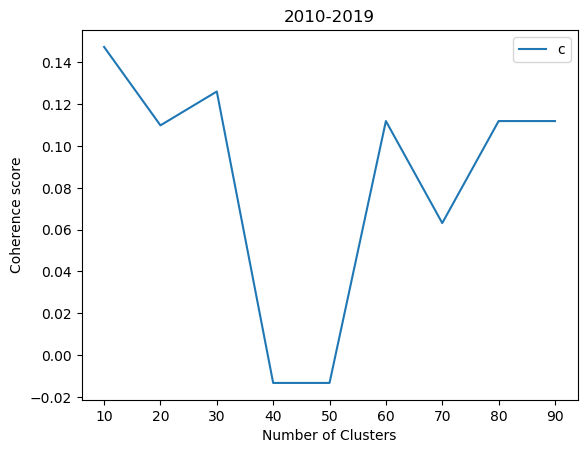

A maximum c_npmi score of 0.14739290451975806 was achieved at K=1


In [48]:
model_index = draw_graph(start, limit, step, coherences, source.split("/")[1])

> Hence, we select the model with the highest coherence value.

### Save Final Model <a class=anchor id=section_9_1_2></a>

In [49]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 10/10 [00:00<00:00, 120.80it/s]


In [50]:
topic_model.save(output+"bert")
with open(output+'hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output+'docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

## Explore Model <a class=anchor id=section_9_2></a>

In [51]:
topic_model = BERTopic.load(output+"bert")
with open(output+'hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output+'docs.pkl', 'rb') as f:
    docs = pickle.load(f)

### Extracting Topics <a class=anchor id=section_9_2_1></a>

After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. 

In [52]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name
0,-1,528,-1_said_company_like_year
1,0,2042,0_said_company_like_year
2,1,77,1_pilot_boeing_plane_flight
3,2,59,2_bride_graduated_father_mother
4,3,25,3_yang_campaign_charity_candidate


> -1 refers to all outliers and should typically be ignored.

Next, let's take a look at a frequent topic that were generated:

In [53]:
# Select the most frequent topic
topic_model.get_topic(0)

[('said', 0.024159884961943122),
 ('company', 0.01892723865746019),
 ('like', 0.01516534993112288),
 ('year', 0.015154551787354302),
 ('time', 0.012952984505324821),
 ('people', 0.012812575946554454),
 ('technology', 0.01163112061807604),
 ('work', 0.011500251609857664),
 ('worker', 0.011092951959412697),
 ('state', 0.011010129990886032)]

**NOTE**: BERTopic is stochastic which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

### Visualizations <a class=anchor id=section_9_2_2></a>

In [54]:
topic_model.visualize_topics()

In [55]:
topic_model.visualize_documents(docs, reduced_embeddings=embeddings)

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [56]:
topic_model.visualize_barchart(top_n_topics=6)

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we create clusters and visualize how they relate to one another.

In [57]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=50)

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [58]:
topic_model.visualize_heatmap(width=1000, height=1000)

Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, to select the best number of words in a topic.

In [59]:
topic_model.visualize_term_rank()